In [37]:
import numpy as np
import pandas as pd
from imblearn import over_sampling
from sklearn import metrics, model_selection, linear_model, naive_bayes, preprocessing
from sklearn import ensemble
from matplotlib import pyplot as plt
import scikitplot as skplt
import xgboost as xgb

In [8]:
train_df = pd.read_csv('data_train.csv')
test_df = pd.read_csv('data_test.csv')

In [9]:
train_df.head()

,userId,eventId,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop,interested,not_interested
0,3044012,1918771225,0,0.000000,0.290735,0.000000,0.175499,0.0,-0.000246,0,0
1,3044012,1502284248,0,0.000000,0.907079,0.447731,0.175499,0.0,0.000000,0,0
2,3044012,2529072432,0,65.239331,0.000000,0.000000,0.175499,0.0,-0.000246,1,0
3,3044012,3072478280,0,0.000000,0.381639,0.186315,0.175499,0.0,0.000000,0,0
4,3044012,1390707377,0,13.993137,1.000000,0.020835,0.175499,0.0,0.000246,0,0


In [10]:
test_df.head()

,userId,eventId,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop
0,1776192,2877501688,0,0.0,0,0,0.089686,0.0,0.000000
1,1776192,3025444328,0,0.0,0,0,0.089686,0.0,0.000246
2,1776192,4078218285,0,0.0,0,0,0.089686,0.0,0.000000
3,1776192,1024025121,0,0.0,0,0,0.089686,0.0,0.000000
4,1776192,2972428928,0,0.0,0,0,0.089686,0.0,0.000000


In [12]:
# 上采样处理样本不均衡问题
X = train_df.loc[:, train_df.columns[train_df.columns != 'invited']]
y = train_df.iloc[:, 2]

sm = over_sampling.SMOTE(random_state=66)
X, y = sm.fit_sample(X, y)
pd.Series(y).value_counts()

1    14744
0    14744
dtype: int64

In [22]:
X_ = train_df.iloc[:, 3:]
y_ = train_df.iloc[:, 2]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_, y_, test_size=0.3, random_state=66)

In [23]:
clf = linear_model.LogisticRegression(solver='lbfgs').fit(X, y)
clf.score(X_, y_)

0.9575269515521496

In [24]:
metrics.confusion_matrix(y_train, clf.predict(X_train))

array([[10315,     0],
       [  463,     0]])

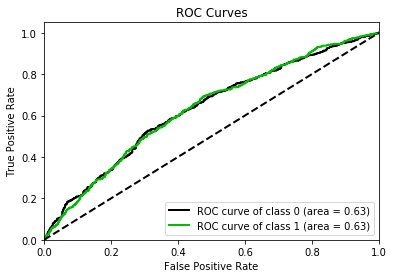

In [25]:
test_proba_df = pd.DataFrame(clf.predict_proba(X_train))
skplt.metrics.plot_roc(y_train, test_proba_df, plot_micro=False, plot_macro=False)

In [29]:
y_.value_counts(), y_.value_counts()[0] / y_.value_counts()[1]

(0    14744
 1      654
 Name: invited, dtype: int64, 22.54434250764526)

0.957042122842828 1
0.957042122842828 22


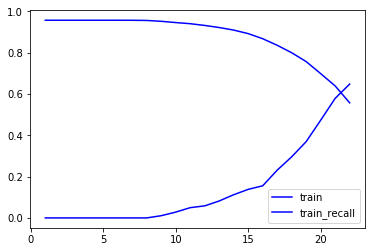

In [34]:
# 因为标签存在严重的不均衡问题  调节class_weight
weight_arr = range(1, 23)
test_scores = []
test_recall_scores = []
train_scores = []
train_recall_scores = []
for weight in weight_arr:
    clf = linear_model.LogisticRegression(solver='lbfgs', 
                                          class_weight={1:weight,0:1},
                                         ).fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    train_recall_scores.append(metrics.recall_score(y_train, clf.predict(X_train)))
        
    test_scores.append(clf.score(X_test, y_test))
    test_recall_scores.append(metrics.recall_score(y_test, clf.predict(X_test)))
    

plt.plot(weight_arr, train_scores, 'b-', label='train')
# plt.plot(weight_arr, test_scores, 'r--', label='test')

plt.plot(weight_arr, train_recall_scores, 'b-', label='train_recall')
# plt.plot(weight_arr, test_recall_scores, 'r--', label='test_recall')

print(max(train_scores), weight_arr[train_scores.index(max(train_scores))])
print(max(train_scores), weight_arr[train_recall_scores.index(max(train_recall_scores))])

plt.legend()
plt.show()

## xgboost

In [42]:
X_train = train_df.iloc[:, 3:]
y_train = train_df.iloc[:, 2]

X_test = test_df.iloc[:, 3:]
y_test = test_df.iloc[:, 2]

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

param = {'silent':True,'obj':'binary:hinge'}
clf = xgb.train(param, dtrain, num_boost_round=100)
pred = clf.predict(X_test)
# metrics.recall_score(y_test, pred)

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [ ]:
param1 = {'silent':True,'obj':'reg:linear',"gamma":0,"eval_metric":"mae"}
cvresult1 = xgb.cv(param1, dfull, num_round,n_fold)

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,181),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,181),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.legend()
plt.show()